# 一、导入库，读取数据


In [ ]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import math
# 不要显示warning
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)
from scipy import stats
from scipy.stats import norm, skew, uniform
# pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points
# from subprocess import check_output
# print(check_output(["ls", "../input"]).decode("utf8")) #check the files available in the directory
from sklearn.preprocessing import StandardScaler,RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn import metrics
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC,LinearRegression
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import xgboost as xgb

# 将多个结果一起输出
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
# @title 定义rrmse，输出精度的函数
def relative_root_mean_squared_error(true, pred):
    num = np.sum(np.square(true - pred))
    den = np.sum(np.square(true))
    squared_error = num/den
    rrmse = np.sqrt(squared_error)
    return rrmse

def print_evaluate(true, predicted , show = True):
    print(f'参与计算精度的数据个数是{len(true)}')
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    # rmse = metrics.root_mean_squared_error(true, predicted)
    rrmse = relative_root_mean_squared_error(true, predicted)
    r2_square = metrics.r2_score(true, predicted)
    if show == True:
      print('MAE:{:.4f}'.format(mae))
      print('MSE:{:.4f}'.format(mse))
      print('RMSE:{:.4f}'.format(rmse))
      print('RRMSE:{:.4f}'.format(rrmse))
      print('R2 Square:{:.4f}'.format(r2_square))
      print('__________________________________')

def show_result(model,X_train, X_test, y_train, y_test,ylog):
  # 注意！！预测的是log1p（setup），所以计算rrmse时要转换回原先的setup
  test_pred = model.predict(X_test)
  train_pred = model.predict(X_train)
  if ylog == True:
    test_pred = np.expm1(test_pred)
    train_pred = np.expm1(train_pred)
    y_train = np.expm1(y_train)
    y_test = np.expm1(y_test)
  print('Train set evaluation:\n_____________________________________')
  print_evaluate(y_train, train_pred)
  print('Test set evaluation:\n_____________________________________')
  print_evaluate(y_test,test_pred)

# 使用k折交叉验证，来看不同数据集在同一模型下所能达到的精度，避免由于测试集分割造成偶然性
# 自定义rrmse作为评分指标

rrmse_error = make_scorer(relative_root_mean_squared_error, greater_is_better=False)
def rrmse_cv(model,X,y,n_folds = 5):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X)
    rmse= np.sqrt(-cross_val_score(model, X, y, scoring="neg_root_mean_squared_error", cv = kf))
    rrmse= -cross_val_score(model, X, y, scoring=rrmse_error, cv = kf)
    print("rrmse score: {:.4f} ({:.4f})\n".format(rrmse.mean(), rrmse.std()))
    print("rmse score: {:.4f} ({:.4f})\n".format(rmse.mean(), rmse.std()))

def cal_lambda(data):
  # 计算box-cox变换最佳的lambda值
  best_lambda = None
  best_transformed_data = None
  best_kurtosis = float('inf')
  for lam in np.arange(-2, 3, 0.05):
      transformed_data = stats.boxcox(data, lmbda=lam)
      # transformed_data = stats.boxcox(d_best['tan'].values, lmbda=lam)
      kurtosis = stats.kurtosis(transformed_data)
      if abs(kurtosis) < abs(best_kurtosis):
          best_lambda = lam
          best_transformed_data = transformed_data
          best_kurtosis = kurtosis
  print(best_lambda)

def cal_final_metric(model,X,y):
  # 得到模型后，使用所有有真实setup的数据（d1）计算整体rrmse
  # 注意X应该已经标准化
  y_pre = model.predict(X)
  print_evaluate(y, y_pre , show = True)
  print('每次使用请注意X是否需要做变形处理！！')

In [ ]:
# @title 读取训练数据(nolab)
# csv_dir='https://raw.githubusercontent.com/3297269/ML_setup/master/alldata_new.csv'
csv_dir = 'https://raw.githubusercontent.com/3297269/ML_setup/master/alldata_new_nolab.csv'
all_data = pd.read_csv(csv_dir)
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1441 entries, 0 to 1440
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   literature           1441 non-null   object 
 1   R2%                  1296 non-null   float64
 2   setup                545 non-null    float64
 3   Stt                  690 non-null    float64
 4   Sinc                 690 non-null    float64
 5   Sig                  690 non-null    float64
 6   Hs(80m or offshore)  1441 non-null   float64
 7   Tp                   1441 non-null   float64
 8   tan                  1441 non-null   float64
 9   D50                  1441 non-null   float64
 10  dataset              1441 non-null   object 
 11  Hs0                  1441 non-null   float64
 12  L0                   1441 non-null   float64
dtypes: float64(11), object(2)
memory usage: 146.5+ KB


In [ ]:
# @title 读取18年数模结果作为测试集test18，评估机器学习模型结果,共56个数据。
test_dir = 'https://raw.githubusercontent.com/3297269/ML_setup/master/test18.csv'
test18 = pd.read_csv(test_dir)
test18.drop(['H0rms','H0s','Tp','tanbeta','maxsetup'], axis=1, inplace=True) # 去掉存在空值的行
test18.rename(columns={'H0s.1': 'Hs','tanbeta.1':'tan','maxsetup.1':'setup'}, inplace=True)
test18.describe()

,Hs,L0,tan,setup
count,56.000000,56.000000,56.000000,56.000000
mean,2.263062,57.653878,0.033961,0.211990
std,1.161963,66.633501,0.028720,0.132921
min,0.307238,6.238874,0.005000,0.026822
25%,1.459751,14.037466,0.020000,0.103878
50%,2.546378,38.992961,0.020000,0.195423
75%,3.152136,56.149864,0.040000,0.287088
max,4.595400,305.704815,0.100000,0.550400


In [ ]:
# @title 看各个变量与setup的线性相关大小
# corrmat = all_data.corr().sort_values(by=['setup'], ascending=False) # 按照setup列从大到小排序
# plt.subplots(figsize=(12,9))
# sns.heatmap(corrmat, vmax=0.9, cmap="Blues", square=True, annot=True)

In [ ]:
# @title 简单处理读取的数据，去掉空值行，去掉setup≤0的行
d0 = all_data.dropna(axis=0, how="any", subset=['tan','Hs0','L0','R2%']).reset_index(drop=True) # 去掉存在空值的行
d0.rename(columns={'Hs0': 'Hs'}, inplace=True)
d0.drop(['Stt','Sinc','Sig','Tp','literature','Hs(80m or offshore)'], axis=1, inplace=True)
d0 = d0.drop(d0[d0['setup'] <= 0].index)
d0["setup_log"] = np.log1p(d0["setup"])
d0["Hs_log"] = np.log1p(d0["Hs"])
d0["tan_square"] = np.power(d0["tan"],2)
d0["L0_sqrt"] = np.sqrt(d0["L0"])
d0.describe() # 还剩1287个数据,其中755个没有setup

,R2%,setup,tan,D50,Hs,L0,setup_log,Hs_log,tan_square,L0_sqrt
count,1283.000000,532.000000,1283.000000,1283.000000,1283.000000,1283.000000,532.000000,1283.000000,1283.000000,1283.000000
mean,2.498262,0.468733,0.121008,10.523903,2.046196,169.232480,0.366754,1.038217,0.018459,12.580423
std,1.719663,0.282578,0.061800,18.028265,1.244248,93.558133,0.186456,0.386391,0.020042,3.312701
min,0.137000,0.006000,0.009000,0.200000,0.127472,21.413259,0.005982,0.119978,0.000081,4.627446
25%,1.248267,0.256000,0.088500,0.360000,1.138097,108.378608,0.227932,0.759916,0.007832,10.410505
50%,2.022876,0.413000,0.108761,3.000000,1.916000,156.077682,0.345715,1.070213,0.011829,12.493105
75%,3.584923,0.657750,0.126290,10.000000,2.450067,192.649961,0.505461,1.238394,0.015949,13.879840
max,12.669592,1.549000,0.286551,50.000000,7.174100,875.218380,0.935701,2.100971,0.082112,29.584090


In [ ]:
# @title 将d0分为两部分，有setup的数据集为d1，没有setup的数据集为d2
d1 = d0.dropna(axis=0, how="any", subset=['setup']).copy()
d2 = d0[d0['setup'].isna()]
d2['have_setup'] = 0
d1['have_setup'] = 1

In [ ]:
# @title 在d1中取20%作为测试集
d1_val = d1.sample(round(len(d1)*0.2))
d1_train = d1.drop(d1_val.index)
d1_all = d1.copy()
d1 = d1_train.copy()

In [ ]:
# @title 比较d1与test18的分布
# plt.hist(d1['setup'], density=True, bins=20, alpha=0.5, label='d1')
# plt.hist(test18['setup'], density=True, bins=20, alpha=0.5, label='test18')

# # 添加标签和图例
# plt.xlabel('Value')
# plt.ylabel('Frequency')
# plt.title('Comparison of Data Distributions')
# plt.legend()

#二、使用全部有setup的532个数据（d1）第一次建模


<Figure size 1000x800 with 0 Axes>

<Axes: >

<Axes: xlabel='setup', ylabel='Density'>

<Axes: >

<Axes: xlabel='Hs', ylabel='Density'>

<Axes: >

<Axes: xlabel='tan', ylabel='Density'>

<Axes: >

<Axes: xlabel='L0', ylabel='Density'>

D50           1.989269
Hs            0.787259
L0            0.762216
setup         0.696699
tan_square    0.364037
R2%           0.292282
setup_log     0.253679
Hs_log        0.125266
L0_sqrt       0.097453
have_setup    0.000000
tan          -0.467508
dtype: float64


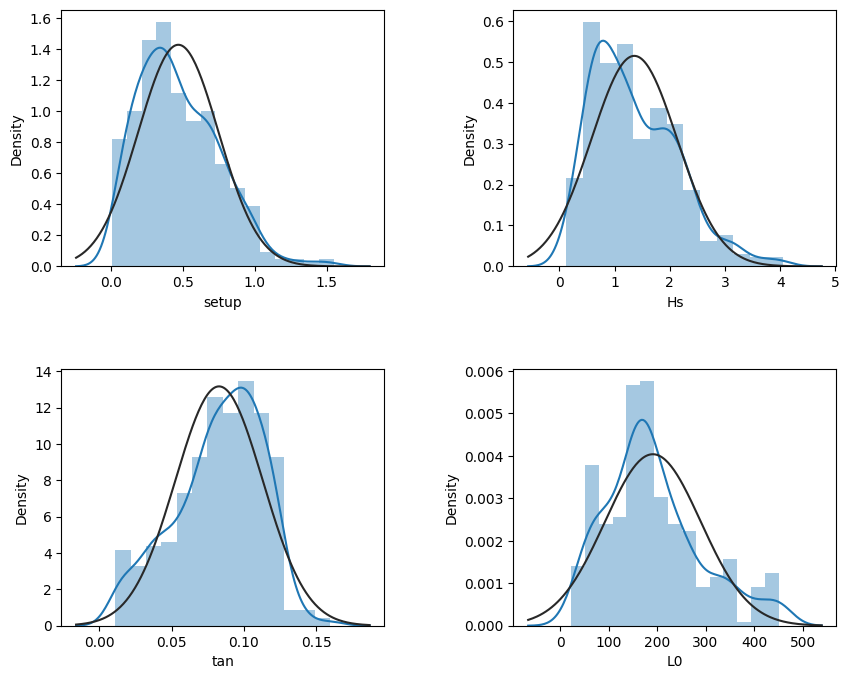

In [ ]:
# @title 作图看d1各个特征的分布并计算峰度。d1数据整体分布较好，skew基本小于1，不用做变换
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
sns.distplot(d1['setup'] , fit=norm);
plt.subplot(2, 2, 2)
sns.distplot(d1['Hs'] , fit=norm);
plt.subplot(2, 2, 3)
sns.distplot(d1['tan'] , fit=norm);
plt.subplot(2, 2, 4)
sns.distplot(d1['L0'] , fit=norm);
print(d1.skew().sort_values(ascending=False))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

<Figure size 1200x600 with 0 Axes>

<Axes: >

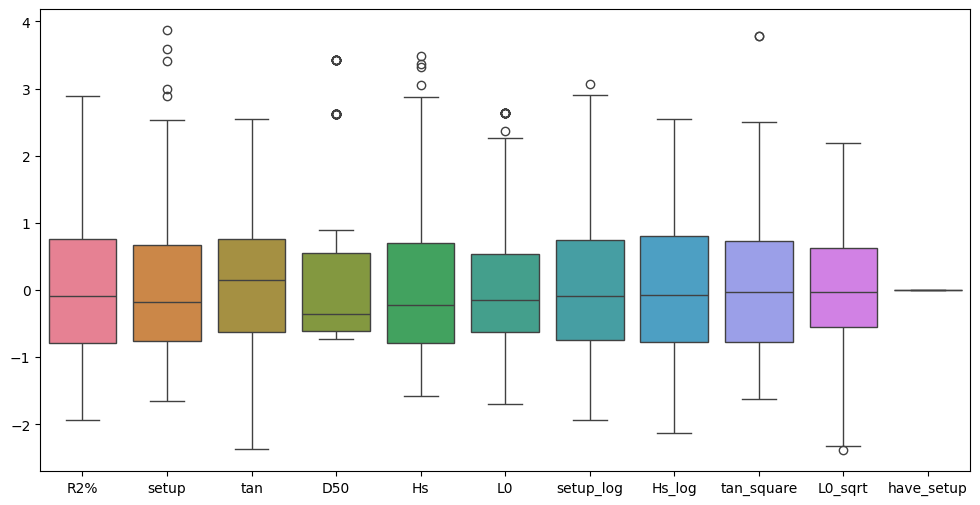

In [ ]:
# @title 检查d1，可发现离群不严重。
scalar = StandardScaler()
d1_scale = pd.DataFrame(scalar.fit_transform(d1.drop('dataset', axis=1).values),columns=d1.drop('dataset', axis=1).columns)
plt.figure(figsize=(12, 6))
sns.boxplot(d1_scale)

In [ ]:
# @title 使用optuna调参寻找最佳xgboost参数
def optuna_xgb(X,y,n_trials=100):
  import xgboost as xgb
  try:
    import optuna
  except ImportError:
    !pip install optuna -q
    import optuna

  def objective(trial):
    dtrain = xgb.DMatrix(X, label=y)
    param = {
        "verbosity": 0,
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "booster": "dart",
        # "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "grow_policy": "lossguide",
        # "lambda": trial.suggest_float("lambda", 0.1, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 0.1, 1.0, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0, step=5)
    }
    param["max_depth"] = trial.suggest_int("max_depth", 1, 5)
    param["eta"] = trial.suggest_float("eta", 1e-8, 0.3, log=True)
    param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
    param["min_child_weight"] = trial.suggest_int("min_child_weight", 3, 10)

    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "test-rmse")
    history = xgb.cv(param, dtrain, nfold=5, metrics='rmse', num_boost_round=100, callbacks=[pruning_callback])
    rmse = history["test-rmse-mean"].values[-1]
    return rmse

  pruner = optuna.pruners.MedianPruner(n_warmup_steps=5)
  study = optuna.create_study(pruner=pruner, direction="minimize")
  study.optimize(objective, n_trials=n_trials)
  print("Number of finished trials: {}".format(len(study.trials)))
  print("Best trial:")
  trial = study.best_trial
  print("  Value: {}".format(trial.value))
  print("  Params: ")
  print(trial.params)
  # from optuna.visualization import plot_param_importances
  # plot_param_importances(study)
  return trial.params

In [ ]:
# 不发生数据泄露的pipeline缩放
# steps = list()
# steps.append(('scaler', MinMaxScaler()))
# steps.append(('model', LogisticRegression()))
# pipeline = Pipeline(steps=steps)
# # define the evaluation procedure
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# # evaluate the model using cross-validation
# scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

In [ ]:
# @title optuna调参过程可视化
# 可视化不同超参数的重要性
# from optuna.visualization import plot_param_importances
# plot_param_importances(study)

# @title 可视化优化的过程
# from optuna.visualization import plot_optimization_history
# plot_optimization_history(study)

# optuna.visualization.plot_slice(study)

In [ ]:
# @title 使用xgboost调优选择最佳参数后建模，模型最小rrmse=0.1167
X = d1[['Hs','tan','L0']].values
y = d1['setup'].values
scalar1 = StandardScaler()
X_scale = scalar1.fit_transform(X)

# best_param_d1 = optuna_xgb(X_scale,y,n_trials=200)
best_param_d1 = {'alpha': 0.18838438950099032, 'subsample': 0.5, 'max_depth': 5, 'eta': 0.22201054440466547, 'gamma': 0.000396927657304194, 'min_child_weight': 3}
xgb1 = XGBRegressor(**best_param_d1)
xgb1.fit(X_scale, y)
# 得到最佳模型xgb1

X_all = scalar1.transform(d1[['Hs','tan','L0']].values) # 注意！这里一定要用训练模型一样的缩放
y = d1['setup'].values
print('此时模型在d1数据上的精度为：')
cal_final_metric(xgb1,X_all,y)

print('此时模型在数模数据上的精度为：')
cal_final_metric(xgb1,scalar1.transform(test18[['Hs','tan','L0']].values),test18['setup'].values)

print('此时模型在测试数据上的精度为：')
cal_final_metric(xgb1,scalar1.transform(d1_val[['Hs','tan','L0']].values),d1_val['setup'].values)

XGBRegressor(alpha=0.18838438950099032, base_score=None, booster=None,
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.22201054440466547,
             eval_metric=None, feature_types=None, gamma=0.000396927657304194,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None, ...)

此时模型在d1数据上的精度为：
参与计算精度的数据个数是426
MAE:0.0409
MSE:0.0031
RMSE:0.0556
RRMSE:0.1021
R2 Square:0.9604
__________________________________
每次使用请注意X是否需要做变形处理！！
此时模型在数模数据上的精度为：
参与计算精度的数据个数是56
MAE:0.1060
MSE:0.0165
RMSE:0.1285
RRMSE:0.5149
R2 Square:0.0482
__________________________________
每次使用请注意X是否需要做变形处理！！
此时模型在测试数据上的精度为：
参与计算精度的数据个数是106
MAE:0.1133
MSE:0.0270
RMSE:0.1642
RRMSE:0.2950
R2 Square:0.6870
__________________________________
每次使用请注意X是否需要做变形处理！！


In [ ]:
# @title xgboost等树模型对数据分布不敏感，对特征做b-box变换不影响结果
# X = d1[['Hs_log','tan_square','L0_sqrt']].values
# y = d1['setup'].values
# scalar2 = StandardScaler()
# X_scale = scalar2.fit_transform(X)
# best_param = {'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 0.8164256459214504, 'reg_lambda': 0.8970365433738731, 'subsample': 0.7}
# xgb_best = XGBRegressor(**best_param)
# xgb_best.fit(X_scale, y)
# X = scalar2.transform(d1[['Hs_log','tan_square','L0_sqrt']].values) # 注意！这里一定要用训练模型一样的缩放
# d1["setup_pre"]  = xgb_best.predict(X)
# print_evaluate(d1['setup'], d1["setup_pre"] , show = True)

# 三、利用runup数据补充标签
** 原数据只有532个，为增加泛化性，进一步补充数据。**

In [ ]:
# @title 建立新的xgboost模型，加入相关度非常高的R2%来建立预测模型
X = d1[['Hs','tan','L0','R2%']].values
y = d1['setup'].values
# X = d1[['Hs_log','tan_square','L0_sqrt','R2%']].values
# y = d1['setup_log'].values
scalar2 = StandardScaler()
X_scale = scalar2.fit_transform(X)

# best_param_d2 = optuna_xgb(X_scale,y,n_trials=200)
best_param_d2 = {'alpha': 0.2778268007054582, 'subsample': 0.5, 'max_depth': 5, 'eta': 0.20758145829749824, 'gamma': 1.372184691627056e-07, 'min_child_weight': 4}

In [ ]:
# @title 使用新建的xgb2模型预测缺失的setup值。由于R2%与setup有非常高的相关关系，所以当特征含有R2%时，rrmse可以减小到0.0963
# best_param = best_param_d2
xgb2 = XGBRegressor(**best_param_d2)
xgb2.fit(X_scale, y)

X = scalar2.transform(d1[['Hs','tan','L0','R2%']].values) # 注意！这里一定要用训练模型一样的缩放
setup_pre  = xgb2.predict(X)
print('使用包含runup在内的四个变量建模时，能达到的精度：')
print_evaluate(d1['setup'], setup_pre , show = True)

# 这里的缩放应该与建模时的缩放相同
X_no_setup = scalar2.transform(d2[['Hs','tan','L0','R2%']].values)
d2_pred = xgb2.predict(X_no_setup)

XGBRegressor(alpha=0.2778268007054582, base_score=None, booster=None,
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.20758145829749824,
             eval_metric=None, feature_types=None, gamma=1.372184691627056e-07,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=4, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None, ...)

使用包含runup在内的四个变量建模时，能达到的精度：
参与计算精度的数据个数是426
MAE:0.0364
MSE:0.0026
RMSE:0.0507
RRMSE:0.0930
R2 Square:0.9671
__________________________________


In [ ]:
# @title 将预测的setup填补到数据中，得到新的数据集d3，d3的数据集比d1多了751个，增加了141%
# 增加的d2本身与原d1数据分布不同，因此对于新增的数据给予小的权重

d2['setup'] = d2_pred
# d3=pd.concat([d1,d2])
# d1.info()
# d2.info()
# d3.info()
print(f'原数据{len(d1)}个')
print(f'增补后数据{len(d3)}个')
print(f'数据增加了{len(d3)-len(d1)}个')

原数据426个
增补后数据1177个
数据增加了751个


<Figure size 1200x500 with 0 Axes>

Text(0.5, 0, 'Setup')

Text(0, 0.5, 'Index')

Text(0.5, 1.0, 'd3 setup')

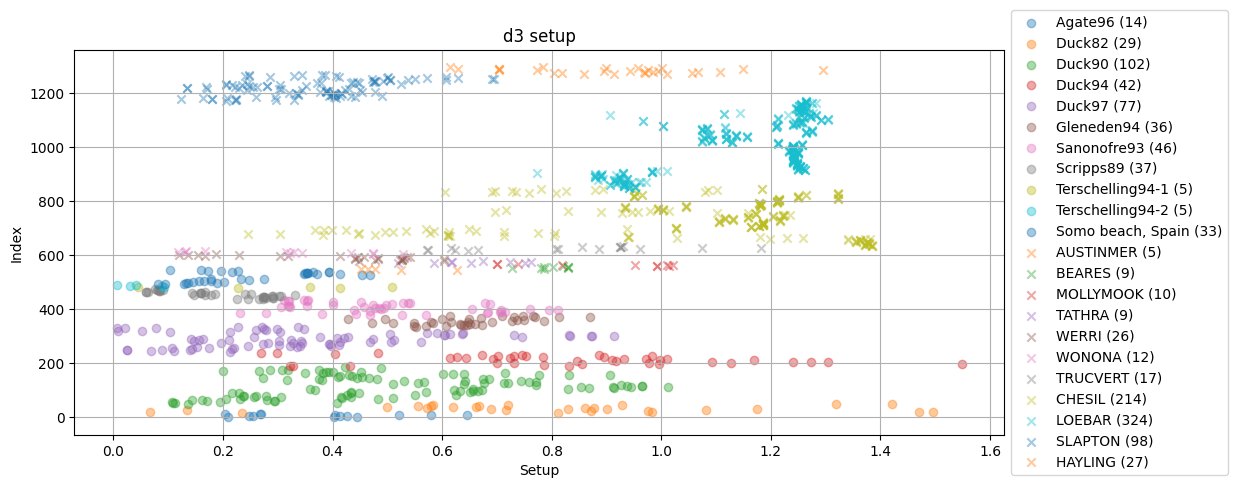

In [ ]:
# @title 看d3数据分布
# CHESIL 与 LOEBAR 两个数据集的setup相对较大，造成d3出现双峰值
unique_datasets = d3["dataset"].unique()
d3_sorted = d3.sort_values(by="setup")
plt.figure(figsize=(12, 5))
for dataset in unique_datasets:
  subset = d3_sorted[d3_sorted["dataset"] == dataset]
  marker = 'o' if dataset in d1['dataset'].unique() else 'x'
  plt.scatter(subset["setup"], subset.index, label=f"{dataset} ({len(subset)})", alpha=0.4, marker=marker)

plt.xlabel("Setup")
plt.ylabel("Index")
plt.title("d3 setup")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()

<Figure size 1000x600 with 0 Axes>

<Axes: >

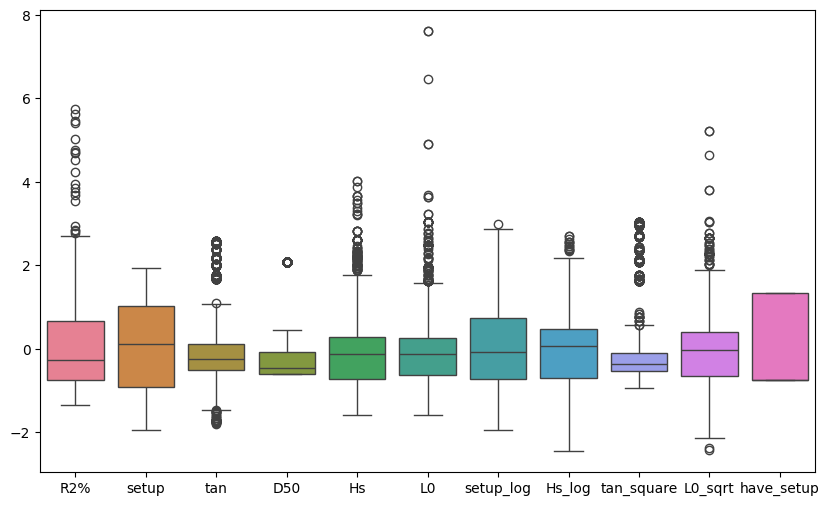

In [ ]:
# @title 检查d3是否存在outliner。绘制箱线图。从图中可以看出L0存在较为严重的偏离点，应作调整
# 箱体代表了数据的四分位数范围，其中箱子的底部和顶部分别表示了数据的第一（Q1）和第三（Q3）四分位数。箱子中间的水平线表示数据的中位数（第二四分位数，Q2）
# 须线通常延伸到数据中的最大和最小值，但不超过1.5倍的IQR（Interquartile Range，四分位数间距）
# 超出须线末端范围的数据点被认为是异常值，通常用点的形式表示。
scalar = StandardScaler()
d3_scale = pd.DataFrame(scalar.fit_transform(d3.drop('dataset', axis=1).values),columns=d3.drop('dataset', axis=1).columns)
plt.figure(figsize=(10, 6))
sns.boxplot(d3_scale)

<img style='float;left;' src='https://img2022.cnblogs.com/blog/1401833/202208/1401833-20220830130351026-2048205807.png' width='30%'>

Text(0.5, 1.0, 'L0 before delete outliner')

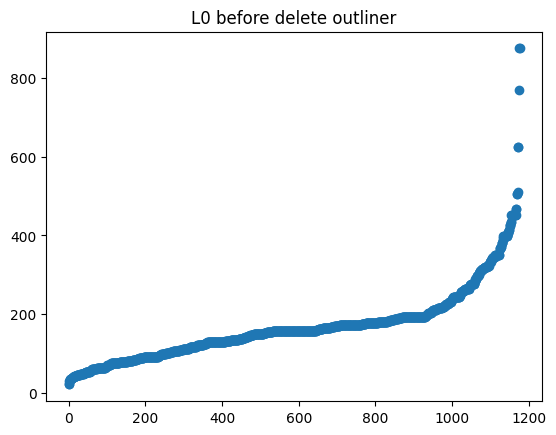

In [ ]:
# @title 单独绘制L0的图
plt.title("L0 before delete outliner")
plt.scatter(x=range(len(d3)),y=d3['L0'].sort_values())

In [ ]:
# @title 删掉L0超过 均值+3倍标准差的数据
mean = d3['L0'].mean()
std_dev = d3['L0'].std()
# 计算阈值
threshold = mean + 3 * std_dev
# 找出大于阈值的数据
result = d3['L0'][d3['L0'] > threshold]
d_best = d3.drop(d3[d3['L0'] > threshold].index)

Text(0.5, 1.0, 'L0 after delete outliner')

<Figure size 1000x600 with 0 Axes>

<Axes: >

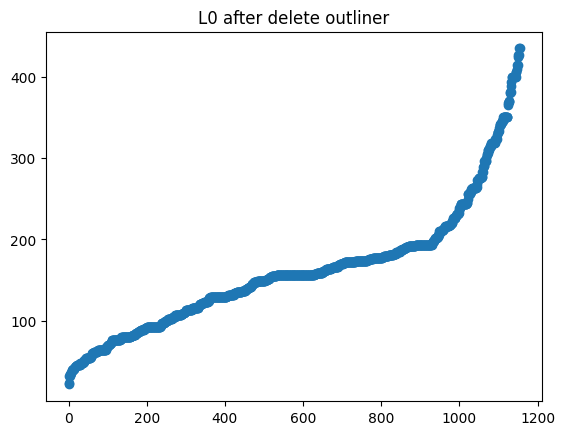

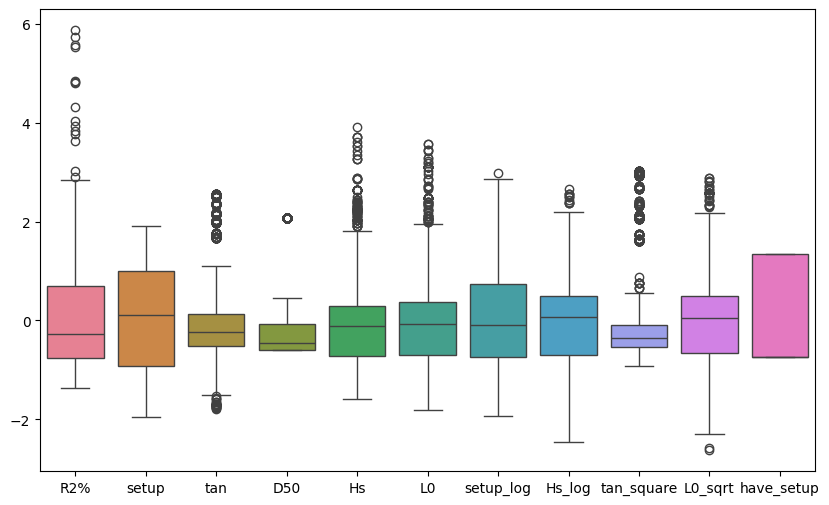

In [ ]:
# @title 再绘制散点图与箱线图
plt.title("L0 after delete outliner")
plt.scatter(x=range(len(d_best)),y=d_best['L0'].sort_values())

scalar = StandardScaler()
d_best_scale = pd.DataFrame(scalar.fit_transform(d_best.drop('dataset', axis=1).values),columns=d_best.drop('dataset', axis=1).columns)
# plt.title("boxfig after delete outliner")
plt.figure(figsize=(10, 6))
sns.boxplot(d_best_scale)

In [ ]:
# @title box-cox变换
d_best["Hs_box"] = stats.boxcox(d_best['Hs'].values, lmbda=0.35)
d_best["L0_box"] = stats.boxcox(d_best['L0'].values, lmbda=0.3)
d_best["tan_box"] = stats.boxcox(d_best['tan'].values, lmbda=0.6)
print(d_best.skew().sort_values(ascending=False))

tan_square    1.781548
R2%           1.565915
D50           1.518861
Hs            1.164672
tan           1.101734
L0            1.081459
have_setup    0.591157
tan_box       0.573816
L0_sqrt       0.338362
setup_log     0.309756
Hs_log        0.045264
L0_box        0.026692
Hs_box       -0.035426
setup        -0.179479
dtype: float64


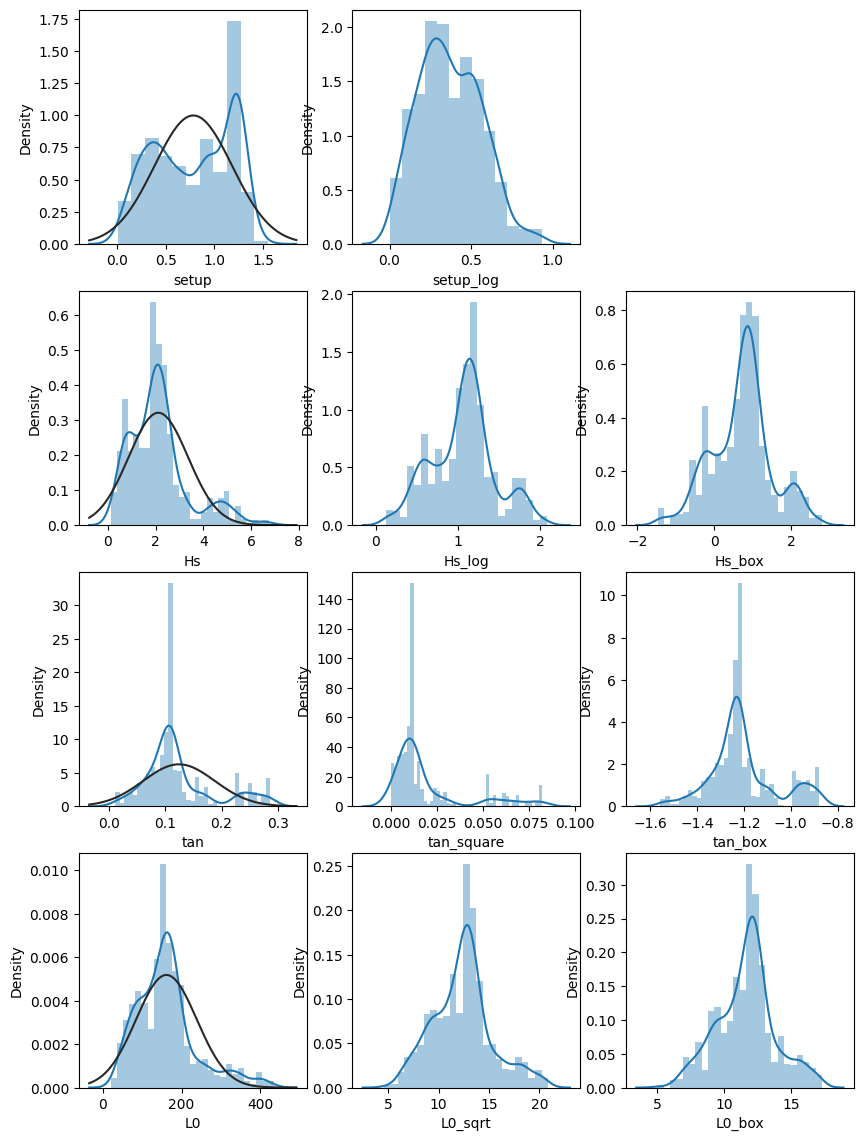

In [ ]:
# @title 绘制转换后的图
plt.figure(figsize=(10, 14))
plt.subplot(4, 3, 1)
sns.distplot(d_best['setup'] , fit=norm);
plt.subplot(4, 3, 4)
sns.distplot(d_best['Hs'] , fit=norm);
plt.subplot(4, 3, 7)
sns.distplot(d_best['tan'] , fit=norm);
plt.subplot(4, 3, 10)
sns.distplot(d_best['L0'] , fit=norm);
plt.subplot(4, 3, 2)
sns.distplot(d_best['setup_log'] );
plt.subplot(4, 3, 5)
sns.distplot(d_best['Hs_log'] );
plt.subplot(4, 3, 8)
sns.distplot(d_best['tan_square']);
plt.subplot(4, 3, 11)
sns.distplot(d_best['L0_sqrt'] );
# plt.subplot(4, 3, 3)
# sns.distplot(d_best['setup_box'] );
plt.subplot(4, 3, 6)
sns.distplot(d_best['Hs_box'] );
plt.subplot(4, 3, 9)
sns.distplot(d_best['tan_box'] );
plt.subplot(4, 3, 12)
sns.distplot(d_best['L0_box'] );

In [ ]:
# @title 使用增加伪标签并删除L0异常值的数据建模
print(f'此时数据长度{len(d_best)}')
X = d_best[['Hs','tan','L0']].values
y = d_best['setup'].values
scalar3 = StandardScaler()
X_scale = scalar3.fit_transform(X)

# best_param_d3 = optuna_xgb(X_scale,y)
best_param_d3 = {'alpha': 0.113747487451855, 'subsample': 0.7374858747006843, 'max_depth': 5, 'eta': 0.29016633640281453, 'gamma': 9.56011350798386e-07, 'min_child_weight': 9}
xgb3 = XGBRegressor(**best_param_d3)
xgb3.fit(X_scale, y)

此时数据长度1155


XGBRegressor(alpha=0.113747487451855, base_score=None, booster=None,
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.29016633640281453,
             eval_metric=None, feature_types=None, gamma=9.56011350798386e-07,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=9, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None, ...)

In [ ]:
# @title 计算目前的模型rrmse，注意只能用有真实setup的。所有数据处理必须与训练的步骤一模一样
# d1["Hs_box"] = stats.boxcox(d1['Hs'].values, lmbda=0.6)
# d1["L0_box"] = stats.boxcox(d1['L0'].values, lmbda=0.65)
# d1["tan_box"] = stats.boxcox(d1['tan'].values, lmbda=0.55)
# X = scalar3.transform(d1[['Hs_box','tan_box','L0_box']].values) # 注意！这里一定要用训练模型一样的缩放
print('此时模型在d1上的精度为：')
cal_final_metric(xgb3,scalar3.transform(d1_all[['Hs','tan','L0']].values),d1_all['setup'].values)

print('此时模型在数模数据上的精度为：')
cal_final_metric(xgb3,scalar3.transform(test18[['Hs','tan','L0']].values),test18['setup'].values)

print('此时模型在测试集上的精度为：')
cal_final_metric(xgb3,scalar3.transform(d1_val[['Hs','tan','L0']].values),d1_val['setup'].values)


此时模型在d1上的精度为：
参与计算精度的数据个数是532
MAE:0.0628
MSE:0.0096
RMSE:0.0979
RRMSE:0.1790
R2 Square:0.8796
__________________________________
每次使用请注意X是否需要做变形处理！！
此时模型在数模数据上的精度为：
参与计算精度的数据个数是56
MAE:0.1709
MSE:0.0663
RMSE:0.2575
RRMSE:1.0317
R2 Square:-2.8214
__________________________________
每次使用请注意X是否需要做变形处理！！
此时模型在测试集上的精度为：
参与计算精度的数据个数是106
MAE:0.0643
MSE:0.0082
RMSE:0.0908
RRMSE:0.1631
R2 Square:0.9043
__________________________________
每次使用请注意X是否需要做变形处理！！


In [ ]:
# @title 如果使用sample_weight
w_10 = d_best['have_setup']*9+1 #(1:10)
w_5 = d_best['have_setup']*4+1 #(1:5)
w_3 = d_best['have_setup']*2+1 #(1:3)

xgb4 = XGBRegressor(**best_param_d3)
xgb4.fit(scalar3.transform(d_best[['Hs','tan','L0']].values),d_best['setup'].values ,sample_weight=w_3)

print('此时模型在d1_all上的精度为：')
cal_final_metric(xgb4,scalar3.transform(d1_all[['Hs','tan','L0']].values),d1_all['setup'].values)

print('此时模型在数模数据上的精度为：')
cal_final_metric(xgb4,scalar3.transform(test18[['Hs','tan','L0']].values),test18['setup'].values)

print('此时模型在测试集上的精度为：')
cal_final_metric(xgb4,scalar3.transform(d1_val[['Hs','tan','L0']].values),d1_val['setup'].values)

# 使用sample_weight 会导致d1上的精度升高，数模上的精度降低，测试集上精度降低

XGBRegressor(alpha=0.113747487451855, base_score=None, booster=None,
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.29016633640281453,
             eval_metric=None, feature_types=None, gamma=9.56011350798386e-07,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=9, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None, ...)

此时模型在d1_all上的精度为：
参与计算精度的数据个数是532
MAE:0.0448
MSE:0.0068
RMSE:0.0823
RRMSE:0.1505
R2 Square:0.9149
__________________________________
每次使用请注意X是否需要做变形处理！！
此时模型在数模数据上的精度为：
参与计算精度的数据个数是56
MAE:0.1877
MSE:0.0682
RMSE:0.2611
RRMSE:1.0462
R2 Square:-2.9293
__________________________________
每次使用请注意X是否需要做变形处理！！
此时模型在测试集上的精度为：
参与计算精度的数据个数是106
MAE:0.0405
MSE:0.0037
RMSE:0.0605
RRMSE:0.1087
R2 Square:0.9575
__________________________________
每次使用请注意X是否需要做变形处理！！


In [ ]:
# @title 使用optuna调参寻找最佳lightgbm参数
def optuna_lgbm(X,y,n_trials = 500):

  import lightgbm as lgb
  try:
    import optuna
  except ImportError:
    !pip install optuna -q
    import optuna

  def objective(trial):
    dtrain = lgb.Dataset(X, label=y)
    param = {
        'boosting_type': 'dart',
        "verbosity": -1,
        'objective': 'regression',
        "metric": "rmse",
        # "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 1.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 10, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0, step=5),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 0.9),
        "min_child_samples": trial.suggest_int("min_child_samples", 15, 50)
    }
    param["num_leaves"] = trial.suggest_int("num_leaves", 2, 32)
    param["max_depth"] = trial.suggest_int("max_depth", 2, 6)
    param["eta"] = trial.suggest_float("eta", 1e-8, 0.2)
    # param["min_child_weight"] = trial.suggest_int("min_child_weight", 3, 10)
    param['feature_fraction'] = trial.suggest_float("feature_fraction", 0.5, 1.0,step=20)
    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "valid rmse")
    history = lgb.cv(param, dtrain, folds=KFold(n_splits=5), metrics='rmse', num_boost_round=100, callbacks=[pruning_callback])
    rmse = history["valid rmse-mean"][-1]
    return rmse

  pruner = optuna.pruners.MedianPruner(n_warmup_steps=5)
  study = optuna.create_study(pruner=pruner, direction="minimize")
  study.optimize(objective, n_trials=n_trials)
  print("Number of finished trials: {}".format(len(study.trials)))
  print("Best trial:")
  trial = study.best_trial
  print("  Value: {}".format(trial.value))
  print("  Params: ")
  print(trial.params)
  # from optuna.visualization import plot_param_importances
  # plot_param_importances(study)
  return trial.params

In [ ]:
# @title 使用lightgbm建模
# best_param_d1_lgbm = optuna_lgbm(scalar3.transform(d_best[['Hs','tan','L0']].values), d_best['setup'].values,n_trials = 500)
best_param_d1_lgbm = {'reg_alpha': 0.022509643876086862, 'subsample': 0.5, 'colsample_bytree': 0.74607510948986, 'min_child_samples': 16, 'num_leaves': 26, 'max_depth': 5, 'eta': 0.19495690018655532, 'feature_fraction': 0.5}
lgbm1 = LGBMRegressor(verbose=-1,**best_param_d1_lgbm)
lgbm1.fit(scalar3.transform(d_best[['Hs','tan','L0']].values), d_best['setup'].values)

print('此时模型在d1_all上的精度为：')
cal_final_metric(lgbm1,scalar3.transform(d1_all[['Hs','tan','L0']].values),d1_all['setup'].values)

print('此时模型在数模数据上的精度为：')
cal_final_metric(lgbm1,scalar3.transform(test18[['Hs','tan','L0']].values),test18['setup'].values)

print('此时模型在测试集上的精度为：')
cal_final_metric(lgbm1,scalar3.transform(d1_val[['Hs','tan','L0']].values),d1_val['setup'].values)

LGBMRegressor(colsample_bytree=0.74607510948986, eta=0.19495690018655532,
              feature_fraction=0.5, max_depth=5, min_child_samples=16,
              num_leaves=26, reg_alpha=0.022509643876086862, subsample=0.5,
              verbose=-1)

此时模型在d1_all上的精度为：
参与计算精度的数据个数是532
MAE:0.1017
MSE:0.0198
RMSE:0.1409
RRMSE:0.2575
R2 Square:0.7509
__________________________________
每次使用请注意X是否需要做变形处理！！
此时模型在数模数据上的精度为：
参与计算精度的数据个数是56
MAE:0.1564
MSE:0.0378
RMSE:0.1944
RRMSE:0.7788
R2 Square:-1.1774
__________________________________
每次使用请注意X是否需要做变形处理！！
此时模型在测试集上的精度为：
参与计算精度的数据个数是106
MAE:0.1068
MSE:0.0198
RMSE:0.1409
RRMSE:0.2531
R2 Square:0.7696
__________________________________
每次使用请注意X是否需要做变形处理！！


In [ ]:
X = scalar3.transform(d1_all[['Hs','tan','L0']].values)
y = d1_all['setup'].values
y_xgb = xgb3.predict(X)
y_lgbm = lgbm1.predict(X)
y_avg = y_xgb*0.5+y_lgbm*0.5
print('此时模型在d1_all上的精度为：')
print_evaluate(y,y_avg,show= True)

X = scalar3.transform(test18[['Hs','tan','L0']].values)
y = test18['setup'].values
y_xgb = xgb3.predict(X)
y_lgbm = lgbm1.predict(X)
y_avg = y_xgb*0.5+y_lgbm*0.5
print('此时模型在数模数据上的精度为：')
print_evaluate(y,y_avg,show= True)

X = scalar3.transform(d1_val[['Hs','tan','L0']].values)
y = d1_val['setup'].values
y_xgb = xgb3.predict(X)
y_lgbm = lgbm1.predict(X)
y_avg = y_xgb*0.5+y_lgbm*0.5
print('此时模型在测试集上的精度为：')
print_evaluate(y,y_avg,show= True)

此时模型在d1_all上的精度为：
参与计算精度的数据个数是532
MAE:0.0766
MSE:0.0125
RMSE:0.1118
RRMSE:0.2043
R2 Square:0.8432
__________________________________
此时模型在数模数据上的精度为：
参与计算精度的数据个数是56
MAE:0.1584
MSE:0.0479
RMSE:0.2190
RRMSE:0.8773
R2 Square:-1.7629
__________________________________
此时模型在测试集上的精度为：
参与计算精度的数据个数是106
MAE:0.0812
MSE:0.0116
RMSE:0.1079
RRMSE:0.1939
R2 Square:0.8648
__________________________________


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 11.7 MB/s eta 0:00:00


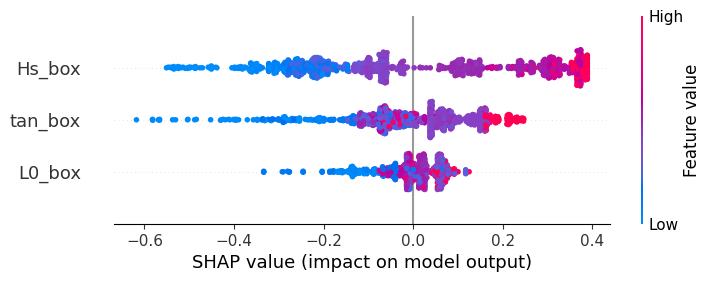

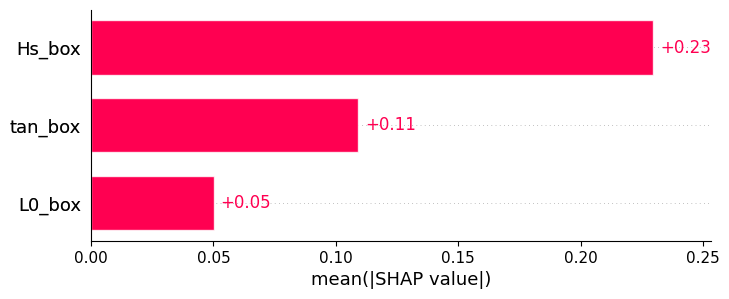

In [ ]:
# https://github.com/shap/shap
# SHAP（SHapley Additive exPlanations）是一种博弈论方法，用于解释任何机器学习模型的输出。
#
# try:
#   import shap
# except ImportError:
#   !pip install shap -q
#   import shap
# explainer = shap.Explainer(xgb3,feature_names=['Hs_box','tan_box','L0_box'])
# shap_values = explainer(X_scale)

# # visualize the first prediction's explanation
# # shap.plots.waterfall(shap_values[0])

# # summarize the effects of all the features
# shap.plots.beeswarm(shap_values)

# # 只取每个特征的 SHAP 值的平均绝对值来获得标准条形图
# shap.plots.bar(shap_values)

In [ ]:
# d1.to_csv('/content/drive/My Drive/MachineLearning/Data/setup/alldata_new_predict.csv')

# 旧代码

In [ ]:
# @title 使用lightgbm建模
# 调参过程可以参考 https://www.cnblogs.com/bjwu/p/9307344.html
# 以及 https://www.heywhale.com/mw/project/6585325cdcad99bb0a1f4686
lgbm = LGBMRegressor(boosting_type='dart',objective='regression', max_depth=-1,
                    lambda_l1=0.0001, lambda_l2=0, learning_rate=0.1,
                    n_estimators=100, max_bin=200, min_child_samples=5,
                    bagging_fraction=0.75, bagging_freq=5,
                    bagging_seed=7, feature_fraction=0.8,
                    feature_fraction_seed=7, verbose=-1,
                    device = gpu,
                    early_stopping_rounds=10)
# DART（Dropouts meet Multiple Additive Regression Trees）是 LightGBM 中的一种树提升算法，它引入了随机失活（dropout）的思想，以增加模型的鲁棒性和泛化能力。
# DART 适用于许多场景，特别是对于处理过拟合和提高模型的泛化性能有帮助的情况。
# DART 引入了随机失活机制，可以减轻过拟合的问题，对于数据噪声较多或者样本量较小的情况有帮助。
param_lst = {
    'max_depth' : [2, 3, 4, 5],
    'learning_rate' : [0.001, 0.01, 0.1, 0.2],
    'n_estimators' : [100, 300, 500],
    'lambda_l1' : uniform(0.01, 1),
    'lambda_l2' : [0, 0.1, 0.5, 1],
    'feature_fraction' : [0.4, 0.6, 0.8],
    'num_leaves' : [15,20,25,30],
    'subsample' : [0.8,0.9,1.0]
}

lightgbm = RandomizedSearchCV(estimator = lgbm, param_distributions = param_lst,
                              n_iter = 100, scoring = 'neg_root_mean_squared_error',
                              cv = 5
                              )

lightgbm_search = lightgbm.fit(X_scale, y)
best_param = lightgbm_search.best_params_
# best_param ={'n_estimators': 1000, 'min_child_samples': 5, 'max_depth': 4, 'learning_rate': 0.01, 'lambda_l2': 0.0001, 'lambda_l1': 0.01, 'feature_fraction': 0.8}
lgbm_best = LGBMRegressor(verbose=-1,**best_param) # verbose=-1避免输出[Warning]
print(best_param)
lgbm_best.fit(X_scale, y)

X = scalar3.transform(d1[['Hs_box','tan_box','L0_box']].values) # 注意！这里一定要用训练模型一样的缩放
# X = scalar3.transform(d1[['Hs','tan','L0']].values) # 注意！这里一定要用训练模型一样的缩放
d1["setup_pre"]  = lgbm_best.predict(X)
print_evaluate(d1['setup'], d1["setup_pre"] , show = True)

from lightgbm import plot_importance
plot_importance(lgbm_best,3)
plt.show()

In [ ]:
# @title 可以使用sklearn-onnx来保存模型与pipeline
# https://cloud.google.com/bigquery/docs/making-predictions-with-sklearn-models-in-onnx-format?hl=zh-cn

In [ ]:
# @title 比较几个数据集。
# d1是所有包含setup数据，
# d2是所有只缺setup的数据，
# d3=d1+d2，
# d4是d3去掉砾石海岸，
# d5是d3去掉D50超过10的项，
# d6是d4去掉D50 nan项

d4 = d3.drop(d3[d3['D50'] >= 3].index)
d5 = d3.drop(d3[d3['D50'] >= 10].index)
d6 = d4.dropna(axis=0, how="any", subset=['D50']).reset_index(drop=True) # 去掉存在空值的行


In [ ]:
# @title 计算交叉验证的rrmse，误差最小的是d3
best_param = {'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 0.8164256459214504, 'reg_lambda': 0.8970365433738731, 'subsample': 0.7}
xgb1 = XGBRegressor(**best_param)
rrmse_cv(xgb1,d1[['Hs','tan','L0']].values, d1['setup'])
rrmse_cv(xgb1,d3[['Hs','tan','L0']].values, d3['setup'])
rrmse_cv(xgb1,d4[['Hs','tan','L0']].values, d4['setup'])
rrmse_cv(xgb1,d5[['Hs','tan','L0']].values, d5['setup'])
rrmse_cv(xgb1,d6[['Hs','tan','L0']].values, d6['setup'])
# 比较四个数据集。d1是所有包含setup数据，d2是所有只缺setup的数据，d3=d1+d2，d4是d3去掉D50>=3，d5是d3去掉D50>=10的项，d6是d4去掉D50的nan项
# d1 532个数据 score: 0.1486 (0.0177)
# d3 1431个数据 score: 0.1523 (0.0515)
# d4 764个数据 score: 0.1387 (0.0345)
# d5 1092个数据 score: 0.1628 (0.0645)
# d6 620个数据 score: 0.1612 (0.0232)
# 表现最好的是d3


rrmse score: 0.4084 (0.0713)

rmse score: 0.4503 (0.0556)

rrmse score: 0.3000 (0.0902)

rmse score: 0.4484 (0.0377)

rrmse score: 0.3455 (0.1221)

rmse score: 0.4190 (0.0948)

rrmse score: 0.3355 (0.1294)

rmse score: 0.4496 (0.0414)

rrmse score: 0.4201 (0.0655)

rmse score: 0.4791 (0.0555)



In [ ]:
# d1只包含setup
# RRMSE:0.2575
X_train1, X_test1, y_trai1n, y_test1 = train_test_split(d1[['Hs_log','tan_square','L0_sqrt']].values, d1['setup_log'], test_size=0.3, random_state=42)
pipeline1 = Pipeline([('std_scalar', StandardScaler())])
X_train1 = pipeline1.fit_transform(X_train1)
X_test1 = pipeline1.transform(X_test1)

best_param = {'reg_lambda': 0.001, 'reg_alpha': 0.1, 'n_estimators': 3000, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.3}
xgb1 = XGBRegressor(**best_param)
xgb1.fit(X_train1,y_train1)
show_result(xgb1,X_train1, X_test1, y_train1, y_test1)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=3000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Train set evaluation:
_____________________________________
MAE:0.0336
MSE:0.0022
RMSE:0.0465
RRMSE:0.0837
R2 Square:0.9739
__________________________________
Test set evaluation:
_____________________________________
MAE:0.1050
MSE:0.0251
RMSE:0.1585
RRMSE:0.3004
R2 Square:0.6542
__________________________________


In [ ]:
# d3包含所有伪标签
# RRMSE:0.2326
X_train3, X_test3, y_train3, y_test3 = train_test_split(d3[['Hs_log','tan_square','L0_sqrt']].values, d3['setup_log'], test_size=0.3) #, random_state=42
pipeline3 = Pipeline([('std_scalar', StandardScaler())])
X_train3 = pipeline3.fit_transform(X_train3)
X_test3 = pipeline3.transform(X_test3)

best_param = {'reg_lambda': 0.001, 'reg_alpha': 0.1, 'n_estimators': 3000, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.3}
xgb3 = XGBRegressor(**best_param)
xgb3.fit(X_train3,y_train3)
show_result(xgb3,X_train3, X_test3, y_train3, y_test3)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=3000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Train set evaluation:
_____________________________________
MAE:0.0206
MSE:0.0013
RMSE:0.0363
RRMSE:0.0868
R2 Square:0.9666
__________________________________
Test set evaluation:
_____________________________________
MAE:0.0525
MSE:0.0132
RMSE:0.1147
RRMSE:0.2732
R2 Square:0.6674
__________________________________


In [ ]:
# d4是去掉砾石海岸伪标签的数据
# RRMSE:0.2305
X_train4, X_test4, y_train4, y_test4 = train_test_split(d4[['Hs_log','tan_square','L0_sqrt']].values, d4['setup_log'], test_size=0.3, random_state=42)
pipeline4 = Pipeline([('std_scalar', StandardScaler())])
X_train4 = pipeline4.fit_transform(X_train4)
X_test4 = pipeline4.transform(X_test4)

best_param = {'reg_lambda': 0.001, 'reg_alpha': 0.1, 'n_estimators': 3000, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.3}
xgb4 = XGBRegressor(**best_param)
xgb4.fit(X_train4,y_train4)
show_result(xgb4,X_train4, X_test4, y_train4, y_test4)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=3000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Train set evaluation:
_____________________________________
MAE:0.0256
MSE:0.0018
RMSE:0.0427
RRMSE:0.0861
R2 Square:0.9673
__________________________________
Test set evaluation:
_____________________________________
MAE:0.0853
MSE:0.0247
RMSE:0.1572
RRMSE:0.3084
R2 Square:0.6039
__________________________________


In [ ]:
# RRMSE:0.2319
X_train5, X_test5, y_train5, y_test5 = train_test_split(d5[['Hs_log','tan_square','L0_sqrt']].values, d5['setup_log'], test_size=0.3, random_state=44)
pipeline5 = Pipeline([('std_scalar', StandardScaler())])
X_train5 = pipeline5.fit_transform(X_train5)
X_test5 = pipeline5.transform(X_test5)

best_param = {'reg_lambda': 0.001, 'reg_alpha': 0.1, 'n_estimators': 3000, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.3}
xgb5 = XGBRegressor(**best_param)
xgb5.fit(X_train5,y_train5)
show_result(xgb5,X_train5, X_test5, y_train5, y_test5)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=3000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Train set evaluation:
_____________________________________
MAE:0.0202
MSE:0.0011
RMSE:0.0327
RRMSE:0.0734
R2 Square:0.9749
__________________________________
Test set evaluation:
_____________________________________
MAE:0.0726
MSE:0.0211
RMSE:0.1452
RRMSE:0.3044
R2 Square:0.6031
__________________________________


In [ ]:
xgb = XGBRegressor(booster='gbtree', objective='reg:squarederror',tree_method="hist", device="cuda") # 使用GPU计算
param_lst = {
    'learning_rate' : [0.01, 0.1, 0.15, 0.3, 0.5],
    'n_estimators' : [100, 500, 1000, 2000, 3000],
    'max_depth' : [1, 2, 3, 4, 5],
    'min_child_weight' : [1, 5, 10, 20],
    'reg_alpha' : [0.001, 0.01, 0.1],
    'reg_lambda' : [0.001, 0.01, 0.1]
}
# xgb_reg = GridSearchCV(estimator = xgb, param_grid = param_lst,
#                               scoring = 'neg_root_mean_squared_error',
#                               cv = 5)

xgb_reg = RandomizedSearchCV(estimator = xgb, param_distributions = param_lst,
                               n_iter = 200, scoring = rrmse_scorer,
                               cv = 5)

xgb_search = xgb_reg.fit(X_train4, y_train4)
best_param = xgb_search.best_params_
# 随机100次+GPU耗时7分钟
# best_param = {'reg_lambda': 0.01, 'reg_alpha': 0.1, 'n_estimators': 2000, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.1}
xgb = XGBRegressor(**best_param)
print(best_param)
xgb.fit(X_train4,y_train4)
show_result(xgb,X_train4, X_test4, y_train4, y_test4)

{'reg_lambda': 0.1, 'reg_alpha': 0.1, 'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.1}


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Train set evaluation:
_____________________________________
MAE:0.0312
MSE:0.0025
RMSE:0.0503
RRMSE:0.1014
R2 Square:0.9547
__________________________________
Test set evaluation:
_____________________________________
MAE:0.0852
MSE:0.0236
RMSE:0.1537
RRMSE:0.3015
R2 Square:0.6214
__________________________________


Pearson Correlation
展示各个变量的相关性。

**完美**：如果值接近± 1，那么这就是一个完美的相关性：当一个变量增加时，另一个变量也趋向于增加（如果是正的）或减少（如果是负的）。

**高度相关**：如果系数值介于± 0.50和± 1，那么就说这是一个很强的相关性。

**中度相关**：如果值介于± 0.30和± 0.49，则称为中等相关性。

**低度相关**：当值低于± 0.29时，则表示相关性很小。

**无相关性**：当值为零时。

需要注意的是，它只对线性关系敏感，如果关系是非线性的，即便两个变量具有一一对应的关系，相关系数系数也可能会接近0。例如x和x^2之间的Pearson相关系数是0，但是两个变量并不是独立的。

In [ ]:
# 因为后面会用到很多模型，所以可以把 cross validation 和 fit 的部分写入一个函数，这样每次把分类器投入到函数中训练，最后返回训练好的模型即可。

def get_model(estimator, parameters, X_train, y_train, scoring):
    model = GridSearchCV(estimator, param_grid=parameters, scoring=scoring)
    model.fit(X_train, y_train)
    return model.best_estimator_

In [ ]:
# 学习曲线将展示出随着训练样本数量的增加，训练集和验证集的性能变化情况。如果训练集和验证集的性能曲线收敛且趋于平稳，说明模型已经充分学习数据；如果两者之间存在差距，可能存在过拟合或欠拟合问题。

from sklearn.model_selection import learning_curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5), scoring='accuracy'):
    plt.figure(figsize=(10,6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel(scoring)
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, scoring=scoring,
                                                            n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [ ]:
corrmat = d1.corr().sort_values(by=['setup'], ascending=False) # 按照setup列从大到小排序
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, cmap="Blues", square=True, annot=True)

In [ ]:
# data_nonan[['D50']].sort_values('D50').value_counts(sort=0)
# D50
# 0.200    114
# 0.220     13
# 0.250     40
# 0.280     12
# 0.292     18
# 0.340     12
# 0.360    138
# 0.400     42
# 0.750     36
# 0.900     66
# 1.650     29
# 2.000     12
# dtype: int64

PPS的方法适用的问题非常多，应用的方面也很广，此处我们将其归纳为下面几点：


数据分析：PPS的方式可以表示两个数据之间的潜在关系（线性的非线性的），PPS的相关性图是非常好的一种可视化的解释方式；

特征筛选，其特征筛选的方式和Pearson相关性的方式类似，如果我们变量与标签之间的PPS分数很低的话，那么该特征可能和我们的目标变量并不存在任何关系，包括线性的和非线性的关系，可以考虑直接删除处理；

In [ ]:
# 尝试使用ppscore探索变量之间的关系
!pip install ppscore -q
import ppscore as pps
pps.score(all_data, "setup", "tan")
plt.figure(figsize=[10,6])
matrix_df = pps.matrix(all_data)[['x', 'y', 'ppscore']].pivot(columns='y', index='x', values='ppscore')
sns.heatmap(matrix_df, vmin=0, vmax=1, cmap="Blues", linewidths=0.5, annot=True)

In [ ]:
sns.distplot(data_nonan['R2%'] , fit=norm);
# R2% skew=0.269,不再做变换了。

根据绘图可以看出，setup和Hs正偏，tan负偏，L0略微正偏
因此，对setup和Hs取对数，tan取平方，L0取平方根,重新绘图

打印出skew（偏度），可以看出，处理后的数据偏度更接近0，也就是更接近正态分布

In [ ]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.scatter(d4['Hs'], d4['setup']);
plt.xlabel('Hs')
plt.ylabel('setup')
plt.subplot(2, 2, 2)
plt.scatter(d4['L0'], d4['setup']);
plt.xlabel('L0')
plt.ylabel('setup')
plt.subplot(2, 2, 3)
plt.scatter(d4['tan'], d4['setup']);
plt.xlabel('tan')
plt.ylabel('setup')
# plt.subplots_adjust(wspace=0.4, hspace=0.4)

或者直接使用pairplot来绘制

In [ ]:
sns.pairplot(data_nonan, vars=['setup', 'Hs', 'L0','tan'], hue='setup')

## outliner分析

In [ ]:
# 核密度分析
# 核密度估计图(Kernel Density Estimation, KDE)，KDE是非参数检验，用于估计分布未知的密度函数，相比于直方图，它受bin影响更小，绘图呈现更平滑，易于对比数据分布。
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
sns.kdeplot(d4['setup']);
plt.subplot(2, 2, 2)
sns.kdeplot(d4['Hs'] );
plt.subplot(2, 2, 3)
sns.kdeplot(d4['tan']);
plt.subplot(2, 2, 4)
sns.kdeplot(d4['L0']);

In [ ]:
# Hs、setup、tan均无outliner
# L0有几个，不处理了。
# Z-score Method - Detected Outliers: [ 26  28  29  30 368 369 370 371 372 373 374 375 376 377 378 379 380 381
# 382 383 384 385 386 387 388 389 390 391 392 393]
# from scipy.stats import zscore
# z_scores = zscore(data_nonan['L0'])
# threshold = 2  # 设定阈值
# outliers = np.where(np.abs(z_scores) > threshold)[0]
# print("Z-score Method - Detected Outliers:", outliers)

In [ ]:
# def box_outliers(data, fea, scale):
#     '''
#     data: DataFrame，需要处理的数据表格
#     fea: 需要处理的特征
#     scale: 删除尺度
#     return: 异常值删除后的数据表格
#     '''
#     Q1 = data[fea].quantile(0.25)
#     Q3 = data[fea].quantile(0.75)
#     IQR = Q3 - Q1
#     data = data[(data[fea] >= Q1 - scale * IQR) & (data[fea] <= Q3 + scale * IQR)]
#     return data

# box_outliers(data_nonan, 'tan', 3)

In [ ]:
data_nonan.describe()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_nonan[['Hs_log','tan_square','L0_sqrt']].values, data_nonan['setup_log'], test_size=0.3, random_state=42)
X_train1, X_test1, y_train1, y_test1 = train_test_split(data_nonan[['Hs_log','tan_square','L0_sqrt','R2%']].values, data_nonan['setup_log'], test_size=0.3, random_state=42)
X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(data_nonan[['Hs','tan','L0']].values, data_nonan['setup'], test_size=0.3, random_state=42)
print("训练集大小:", len(X_train))
print("测试集大小:", len(X_test))

## 归一化缩放数据
注意这里不能同时标准化train和test，否则会发生数据泄露。应先标准化train再以同样方法标准化test

In [ ]:
pipeline = Pipeline([('std_scalar', StandardScaler())])
X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

pipeline0 = Pipeline([('std_scalar', StandardScaler())])
X_train_original = pipeline0.fit_transform(X_train_original)
X_test_original = pipeline0.transform(X_test_original)

pipeline_1 = Pipeline([('rob_scalar', StandardScaler())])
X_train1 = pipeline.fit_transform(X_train1)
X_test1 = pipeline.transform(X_test1)

In [ ]:
# 交叉验证
cont_features = [col for col in train.columns if col.startswith("cont")]
len(cont_features)
y = train["target"]
kf = KFold(n_splits=5, shuffle=True, random_state=1)
oof = np.zeros(len(train))
score_list = []
fold = 1
test_preds = []


for train_index, test_index in kf.split(train):
    X_train, X_val = train.iloc[train_index], train.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]

    y_pred_list = []
    for seed in [1]:
        dtrain = lgbm.Dataset(X_train[cont_features], y_train)
        dvalid = lgbm.Dataset(X_val[cont_features], y_val)
        print(seed)
        params = {"objective": "regression",
              "metric": "rmse",
              "verbosity": -1,
              "boosting_type": "gbdt",
              "feature_fraction":0.5,
              "num_leaves": 200,
              "lambda_l1":2,
              "lambda_l2":2,
              "learning_rate":0.01,
              'min_child_samples': 50,
              "bagging_fraction":0.7,
              "bagging_freq":1}
        params["seed"] = seed
        model = lgbm.train(params,
                        dtrain,
                        valid_sets=[dtrain, dvalid],
                        verbose_eval=100,
                        num_boost_round=100000,
                        early_stopping_rounds=100
                    )

        y_pred_list.append(model.predict(X_val[cont_features]))
        test_preds.append(model.predict(test[cont_features]))

    oof[test_index] = np.mean(y_pred_list,axis=0)
    score = np.sqrt(mean_squared_error(y_val, oof[test_index]))
    score_list.append(score)
    print(f"RMSE Fold-{fold} : {score}")
    fold+=1

np.mean(score_list)

递归特征消除（RFE）将机器学习模型的实例和要使用的最终期望特征数作为输入。然后，它递归地减少要使用的特征的数量，采用的方法是使用机器学习模型精度作为度量对它们进行排序。
创建一个 for 循环，其中输入特征的数量是我们的变量，这样就可以通过跟踪在每个循环迭代中注册的精度，找出我们的模型所需的最佳特征数量。使用 RFE 支持方法，我们可以找出被评估为最重要的特征的名称（rfe.support 返回一个布尔列表，其中 true 表示一个特征被视为重要，false 表示一个特征不重要）。

In [ ]:

# from sklearn.feature_selection import RFE

# model = RandomForestClassifier(n_estimators=700)
# rfe = RFE(model, 4)
# start = time.process_time()
# RFE_X_Train = rfe.fit_transform(X_Train,Y_Train)
# RFE_X_Test = rfe.transform(X_Test)
# rfe = rfe.fit(RFE_X_Train,Y_Train)
# print(time.process_time() - start)
# print("Overall Accuracy using RFE: ", rfe.score(RFE_X_Test,Y_Test))

In [ ]:
# #Validation function
# def rmsle_cv(model,n_folds = 5):
#     kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train)
#     rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = kf))
#     return(rmse)

使用GridSearchCV来寻找合适的超参数。RandomizedSearch是在一定范围内进行搜索，且要设置搜索的次数，其默认不会对所有的组合进行搜索。

## 1、 线性回归

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)
show_result(lin_reg,X_train, X_test, y_train, y_test)
# scores = {}
# score = rmsle_cv(lin_reg)
# print("LinearRegression: {:.4f} ({:.4f})".format(score.mean(), score.std()))
# scores['LinearRegression'] = (score.mean(), score.std())

NameError: name 'X_train' is not defined

In [ ]:
# # 观察特征的重要性
# importance = model.coef_
# # summarize feature importance
# for i,v in enumerate(importance):
# print('Feature: %0d, Score: %.5f' % (i,v))
# # plot feature importance
# pyplot.bar([x for x in range(len(importance))], importance)
# pyplot.show()

如果采用原来的数据

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_original,y_train_original)
model = lin_reg
test_pred = model.predict(X_test_original)
train_pred = model.predict(X_train_original)
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train_original, train_pred)
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test_original, test_pred)

如果考虑R2%

In [ ]:
lin_reg1 = LinearRegression()
lin_reg1.fit(X_train1,y_train1)
model = lin_reg1
test_pred = model.predict(X_test1)
train_pred = model.predict(X_train1)
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train1, train_pred)
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test1, test_pred)

In [ ]:
for i,j in zip(['Hs_log','tan_square','L0_sqrt','R2%'],lin_reg1.coef_):
  print(f'{i}的系数是{j}\n')

## 2、LASSO岭回归
L1正则化将系数w的l1范数作为惩罚项加到损失函数上，由于正则项非零，这就迫使那些弱的特征所对应的系数变成0。因此L1正则化往往会使学到的模型很稀疏（系数w经常为0），这个特性使得L1正则化成为一种很好的特征选择方法。
Lasso能够挑出一些优质特征，同时让其他特征的系数趋于0。

In [ ]:
param_lst = {
    'alpha' :  [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100],
}
lasso0 = Lasso()
lasso_reg = RandomizedSearchCV(estimator = lasso0, param_distributions = param_lst,
                              n_iter = 100, scoring = 'neg_root_mean_squared_error',
                              cv = 5)
lasso_search = lasso_reg.fit(X_train, y_train)
best_param = lasso_search.best_params_
lasso = Lasso(**best_param)
print(best_param)
lasso.fit(X_train,y_train)
show_result(lasso,X_train, X_test, y_train, y_test)
# score = rmsle_cv(lasso)
# print("LassoRegression: {:.4f} ({:.4f})".format(score.mean(), score.std()))
# scores['LassoRegression'] = (score.mean(), score.std())

## 3、XGBOOST
用xgb.plot_importance来评估每个特征的重要性

In [ ]:
# # 交叉验证
# n_fold = 10
# folds = KFold(n_splits=n_fold, shuffle=True, random_state=1314)

# oof = np.zeros(len(X))
# prediction = np.zeros(len(X_test))
# for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
#     print('第 ' + str(fold_n + 1) + '折：')
#     X_train, X_valid = X[features].iloc[train_index], X[features].iloc[valid_index]
#     y_train, y_valid = y[train_index], y[valid_index]

#     model = lgb.LGBMRegressor(**params, n_estimators=60000, n_jobs=-1)
#     model.fit(X_train, y_train,
#               eval_set=[(X_train, y_train), (X_valid, y_valid)],
#               eval_metric='rmae',
#               verbose=1000,
#               early_stopping_rounds=500)
#     y_pred_valid = model.predict(X_valid)
#     y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
#     oof[valid_index] = y_pred_valid.reshape(-1, )
#     prediction += y_pred
# prediction /= n_fold

In [ ]:
# best:{'reg_lambda': 0.001, 'reg_alpha': 0.01, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.1}
xgb = XGBRegressor(booster='gbtree', objective='reg:squarederror')

param_lst = {
    'learning_rate' : [0.01, 0.1, 0.15, 0.3, 0.5],
    'n_estimators' : [100, 500, 1000, 2000, 3000],
    'max_depth' : [1, 2, 3, 4, 5],
    'min_child_weight' : [1, 5, 10, 20],
    'reg_alpha' : [0.001, 0.01, 0.1],
    'reg_lambda' : [0.001, 0.01, 0.1]
}

xgb_reg = RandomizedSearchCV(estimator = xgb, param_distributions = param_lst,
                              n_iter = 100, scoring = 'neg_root_mean_squared_error',
                              cv = 5)
xgb_search = xgb_reg.fit(X_train, y_train)
best_param = xgb_search.best_params_
xgb = XGBRegressor(**best_param)
print(best_param)
xgb.fit(X_train,y_train)
show_result(xgb,X_train, X_test, y_train, y_test)

# 不使用伪标签时
# Train set evaluation:
# _____________________________________
# MAE:0.0225
# MSE:0.0009
# RMSE:0.0299
# RRMSE:0.0719
# R2 Square:0.9748
# __________________________________
# Test set evaluation:
# _____________________________________
# MAE:0.0700
# MSE:0.0106
# RMSE:0.1032
# RRMSE:0.2575
# R2 Square:0.6761
# __________________________________

如果采用原来的数据

In [ ]:
best_param = {'reg_lambda': 0.001, 'reg_alpha': 0.1, 'n_estimators': 3000, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.3}
xgb = XGBRegressor(**best_param)
xgb.fit(X_train_original,y_train_original)
model = xgb
test_pred = model.predict(X_test_original)
train_pred = model.predict(X_train_original)
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train_original, train_pred)
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test_original, test_pred)

In [ ]:
# @title 使用dtreeviz可视化结果

# 参考 https://github.com/parrt/dtreeviz/blob/master/notebooks/dtreeviz_xgboost_visualisations.ipynb

# %config InlineBackend.figure_format = 'retina' # Make visualizations look good
# #%config InlineBackend.figure_format = 'svg'
# %matplotlib inline

# if 'google.colab' in sys.modules:
#   !pip install -q dtreeviz
#   !pip install -q xgboost==1.5.0


# import xgboost as xgb
# from xgboost import plot_importance, plot_tree, plotting

# import dtreeviz
# import graphviz
# import matplotlib.pyplot as plt
# from matplotlib.pylab import rcParams

# import pandas as pd
# import numpy as np

# random_state = 1234 # get reproducible trees



# features_reg = ["Pclass", "Fare", "Sex_label", "Cabin_label", "Embarked_label", "Survived"]
# target_reg = "Age"

# dtrain_reg = xgb.DMatrix(dataset[features_reg], dataset[target_reg])
# params_reg = {"max_depth":3, "eta":0.05, "objective":"reg:squarederror", "subsample":1}
# xgb_model_reg = xgb.train(params=params_reg, dtrain=dtrain_reg, num_boost_round=8)


# viz_rmodel = dtreeviz.model(model=xgb_model_reg, tree_index=1,
#                             X_train=dataset[features_reg],
#                             y_train=dataset[target_reg],
#                             feature_names=features_reg,
#                             target_name=target_reg)

# viz_rmodel.view()

In [ ]:
# @title 使用shap可视化结果

# https://github.com/shap/shap

# import xgboost
# import shap

# # train an XGBoost model
# X, y = shap.datasets.california()
# model = xgboost.XGBRegressor().fit(X, y)

# # explain the model's predictions using SHAP
# # (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
# explainer = shap.Explainer(model)
# shap_values = explainer(X)

# # visualize the first prediction's explanation
# shap.plots.waterfall(shap_values[0])

## 4、lightgbm

In [ ]:
# {'n_estimators': 1000, 'min_child_samples': 5, 'max_depth': 4, 'learning_rate': 0.01, 'lambda_l2': 0.0001, 'lambda_l1': 0.01, 'feature_fraction': 0.8}
# lgbm = LGBMRegressor(boosting_type='gbdt',objective='regression', max_depth=-1,
#                     lambda_l1=0.0001, lambda_l2=0, learning_rate=0.1,
#                     n_estimators=100, max_bin=200, min_child_samples=5,
#                     bagging_fraction=0.75, bagging_freq=5,
#                     bagging_seed=7, feature_fraction=0.8,
#                     feature_fraction_seed=7, verbose=-1)

# param_lst = {
#     'max_depth' : [1, 2, 3, 4, 5],
#     'learning_rate' : [0.001, 0.01, 0.1, 0.2],
#     'n_estimators' : [100, 300, 500, 1000, 1500],
#     'lambda_l1' : [0.0001, 0.001, 0.01],
#     'lambda_l2' : [0, 0.0001, 0.001, 0.01],
#     'feature_fraction' : [0.4, 0.6, 0.8],
#     'min_child_samples' : [5, 10, 20, 25]
# }

# lightgbm = RandomizedSearchCV(estimator = lgbm, param_distributions = param_lst,
#                               n_iter = 100, scoring = 'neg_root_mean_squared_error',
#                               cv = 5)

# lightgbm_search = lightgbm.fit(X_train, y_train)
# best_param = lightgbm_search.best_params_
best_param ={'n_estimators': 1000, 'min_child_samples': 5, 'max_depth': 4, 'learning_rate': 0.01, 'lambda_l2': 0.0001, 'lambda_l1': 0.01, 'feature_fraction': 0.8}
lgbm = LGBMRegressor(verbose=-1,**best_param) # verbose=-1避免输出[Warning] No further splits with positive gain, best gain: -inf
print(best_param)
lgbm.fit(X_train,y_train)
show_result(lgbm,X_train, X_test, y_train, y_test)

In [ ]:
# 使用R2%
best_param = {'n_estimators': 1000, 'min_child_samples': 5, 'max_depth': 4, 'learning_rate': 0.01, 'lambda_l2': 0.0001, 'lambda_l1': 0.01, 'feature_fraction': 0.8}
lgbm1 = LGBMRegressor(verbose=-1,**best_param) # verbose=-1避免输出[Warning] No further splits with positive gain, best gain: -inf
lgbm1.fit(X_train1,y_train1)
show_result(lgbm1,X_train1, X_test1, y_train1, y_test1)

## 5、catBOOST

In [ ]:
!pip install catboost -q
from catboost import CatBoostRegressor

In [ ]:
# {'rsm': 0.5, 'random_strength': 0.25, 'n_estimators': 1600, 'min_child_samples': 10, 'max_depth': 5, 'learning_rate': 0.01, 'l2_leaf_reg': 0.01}
# cb = CatBoostRegressor(loss_function='RMSE', logging_level='Silent')
# param_lst = {
#     'n_estimators' : [100, 300, 500, 1000, 1300, 1600],
#     'learning_rate' : [0.0001, 0.001, 0.01, 0.1],
#     'l2_leaf_reg' : [0.001, 0.01, 0.05],
#     'random_strength' : [0.25, 0.5 ,1],
#     'max_depth' : [1, 2, 3, 4, 5],
#     'min_child_samples' : [2, 5, 10, 15, 20],
#     'rsm' : [0.5, 0.7, 0.9],
# }

# catboost = RandomizedSearchCV(estimator = cb, param_distributions = param_lst,
#                               n_iter = 100, scoring = 'neg_root_mean_squared_error',
#                               cv = 5)

# catboost_search = catboost.fit(X_train, y_train)
# best_param = catboost_search.best_params_
best_param ={'rsm': 0.5, 'random_strength': 0.25, 'n_estimators': 1600, 'min_child_samples': 10, 'max_depth': 5, 'learning_rate': 0.01, 'l2_leaf_reg': 0.01}
cb = CatBoostRegressor(logging_level='Silent', **best_param)
print(best_param)
cb.fit(X_train,y_train)
show_result(cb,X_train, X_test, y_train, y_test)

## 6、 KRR(KernelRidge)
使用核技巧的岭回归（L2正则线性回归）

In [ ]:
# best = {'kernel': 'polynomial', 'degree': 3, 'coef0': 0.6, 'alpha': 0.25}
from scipy.stats import loguniform
param_lst = {
    "alpha": [0.1, 0.15, 0.2, 0.25],
    "kernel": ['polynomial'],
    "degree": [1, 2, 3],
    'coef0': [0.6 ,0.7 ,0.75 ,0.8 ,0.9 ]
}
krr = KernelRidge()
krr_reg = RandomizedSearchCV(estimator = krr, param_distributions = param_lst,
                              n_iter = 100, scoring = 'neg_root_mean_squared_error',
                              cv = 5)
krr_search = krr_reg.fit(X_train, y_train)
best_param = krr_search.best_params_
krr = KernelRidge(**best_param)
print(best_param)
krr.fit(X_train,y_train)
show_result(krr,X_train, X_test, y_train, y_test)

## 7、AutoGluon

In [ ]:

# import autogluon as ag
# from autogluon import TabularPrediction as task

# train_data = task.Dataset(file_path='https://autogluon.s3.amazonaws.com/datasets/Inc/train.csv')
# train_data = train_data.head(500) # subsample 500 data points for faster demo
# print(train_data.head())

# dir = 'agModels-predictClass' # specifies folder where to store trained models
# predictor = task.fit(train_data=train_data, label=label_column, output_directory=dir)

# test_data = task.Dataset(file_path='https://autogluon.s3.amazonaws.com/datasets/Inc/test.csv')
# y_test = test_data[label_column] # values to predict
# test_data_nolab = test_data.drop(labels=[label_column],axis=1) # delete label column to prove we're not cheating
# print(test_data_nolab.head())

In [ ]:
# @title 尝试添加属性后岭回归，效果很差

# d_best["tan_exp"] = np.exp(d_best["tan"])
# d_best["Hs_exp"] = np.exp(d_best["Hs"])
# d_best["L0_exp"] = np.exp(d_best["L0"])

# X = d_best[['Hs','tan','L0']].values
# from sklearn.preprocessing import FunctionTransformer, PolynomialFeatures
# poly_transformer = PolynomialFeatures(degree=2, include_bias=False)
# X_poly = poly_transformer.fit_transform(X)
# poly_feature_names = poly_transformer.get_feature_names_out(['Hs','tan','L0'])
# for i, col_name in enumerate(poly_feature_names):
#     d_best[col_name] = X_poly[:, i]
# d_best.drop(['D50','R2%','L0_exp'], axis=1, inplace=True) # L0_exp太大了

# X = d_best.drop(['setup_log','setup'], axis=1).values
# y = d_best['setup_log'].values

# pipeline = Pipeline([('scaler', StandardScaler()),('lasso', Lasso())])
# param_lst = {
#     'lasso__alpha' :  [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100],
# }
# # 注意在pipeline中使用时应加上lasso__ 以表明参数是给lasso的
# lasso0 = Lasso()
# lasso_reg = GridSearchCV(estimator = pipeline, param_grid = param_lst,
#                               scoring = 'neg_root_mean_squared_error',
#                               cv = 5)
# lasso_search = lasso_reg.fit(X, y)
# best_param = lasso_search.best_params_
# print(best_param)

# lasso = Lasso(alpha = 0.05)
# core = rrmse_cv(lasso,X,y,n_folds=5)
# lasso.fit(X,y)

# non_zero_coef_indices = np.where(lasso.coef_ != 0)[0]
# non_zero_coefs = lasso.coef_[non_zero_coef_indices]

# namelist = d_best.drop(['setup_log','setup'], axis=1).columns.tolist()
# for name,coef in zip(namelist,lasso.coef_):
#   if coef!=0:
#     print('特征名',name)
#     print('系数：{:.5f}'.format(coef))

# d_best['y_pre'] = np.expm1(d_best['L0']*0.0002-d_best['Hs_exp']*0.00045+d_best['Hs^2']*0.0004+d_best['Hs L0']*0.00022) # log1p的逆运算
# d_best['y_pre'].describe()
# print_evaluate(d_best['setup'] , d_best['y_pre'] )


In [ ]:
# @title 可视化dataframe
# !pip install pygwalker -q
# import pygwalker as pyg
# pyg.walk(df)

In [ ]:
# @title randomsearchcv
# xgb = XGBRegressor(booster='gbtree', objective='reg:squarederror',tree_method='gpu_hist', device="cuda") # 使用GPU计算
# param_lst = {
#     'learning_rate' : np.linspace(0.01,0.2,20),
#     'n_estimators' : [100, 500, 1000, 2000],
#     'max_depth' : [2, 3, 4, 5, 6],
#     'min_child_weight' :[1, 3, 5, 7],
#     'reg_alpha' : uniform(0.1, 1),
#     'reg_lambda' : uniform(0.1, 1),
#     'subsample' : [0.6,0.7,0.8,0.9,1.0]
# }
# xgb_reg = RandomizedSearchCV(estimator = xgb, param_distributions = param_lst,
#                                n_iter = 300, scoring = 'neg_root_mean_squared_error',
#                                cv = 3, n_jobs = -1,verbose=1)
# xgb_search = xgb_reg.fit(X_scale, y)
# best_param = xgb_search.best_params_
# print(best_param)
# print(-xgb_search.best_score_)

# best_param = {'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 0.8164256459214504, 'reg_lambda': 0.8970365433738731, 'subsample': 0.7}

# best_param = {'alpha': 0.001525987327068456, 'subsample': 0.7874775592304251, 'max_depth': 5, 'eta': 0.11197447881761548, 'gamma': 1.0404156476070348e-08, 'min_child_weight': 10}